In [1]:
!pip install tensorflow==2.11.0

In [2]:
import numpy as np
import regex as re
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import statistics
import math
import os
import joblib

from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split

import tensorflow as tf
import tensorflow.keras.backend as K
import tokenizers
from transformers import AutoTokenizer, TFXLMRobertaForSequenceClassification

from collections import Counter

import warnings
warnings.filterwarnings("ignore")

In [3]:
# Detect hardware, return appropriate distribution strategy (you can see that it is pretty easy to set up).
try:
    # TPU detection. No parameters necessary if TPU_NAME environment variable is set (always set in Kaggle)
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.experimental.TPUStrategy(tpu)
    print('Running on TPU ', tpu.master())
except ValueError:
    # Default distribution strategy in Tensorflow. Works on CPU and single GPU.
    strategy = tf.distribute.get_strategy()

print('Number of replicas:', strategy.num_replicas_in_sync)

Number of replicas: 1


In [4]:
MODEL_NAME = 'XMLroberta-base'
MAX_LEN = 128
ARTIFACTS_PATH = '../artifacts/'

BATCH_SIZE = 32 * strategy.num_replicas_in_sync
EPOCHS = 3

if not os.path.exists(ARTIFACTS_PATH):
    os.makedirs(ARTIFACTS_PATH)

In [5]:
df = pd.read_csv('HateSpeechDetection.csv')
df.head()

,Platform,Comment,Hateful
0,Reddit,Damn I thought they had strict gun laws in Ger...,0
1,Reddit,I dont care about what it stands for or anythi...,0
2,Reddit,It's not a group it's an idea lol,0
3,Reddit,So it's not just America!,0
4,Reddit,The dog is a spectacular dancer considering he...,0


In [6]:
X_data = df[['Comment']].to_numpy().reshape(-1)
y_data = df[['Hateful']].to_numpy().reshape(-1)

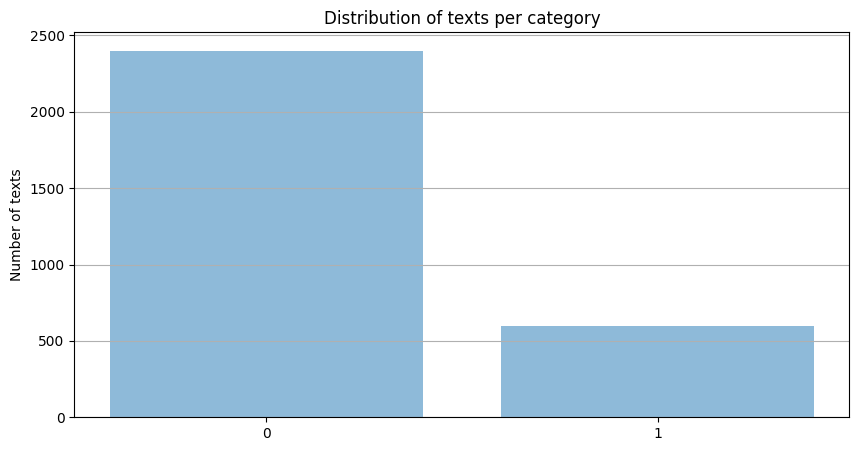

Counter({0: 2400, 1: 600})


In [7]:
categories = df[['Hateful']].values.reshape(-1)

counter_categories = Counter(categories)
category_names = counter_categories.keys()
category_values = counter_categories.values()

y_pos = np.arange(len(category_names))

plt.figure(1, figsize=(10, 5))
plt.bar(y_pos, category_values, align='center', alpha=0.5)
plt.xticks(y_pos, category_names)
plt.ylabel('Number of texts')
plt.title('Distribution of texts per category')
plt.gca().yaxis.grid(True)
plt.show()

print(counter_categories)

In [8]:
def calculate_stats(df, split_char=' '):
    categories = df['Hateful'].unique()

    all_lengths = []
    per_category = {
        'lengths': {c:[] for c in categories},
        'mean': {c:0 for c in categories},
        'stdev': {c:0 for c in categories}
    }

    for index, row in df.iterrows():
        text = row['Comment']
        text = re.sub(r"\s+", ' ', text) # Normalize
        text = text.split(split_char)
        l = len(text)

        target = row['Hateful']

        all_lengths.append(l)
        per_category['lengths'][target].append(l)

    for c in categories:
        per_category['mean'][c] = statistics.mean(per_category['lengths'][c])
        per_category['stdev'][c] = statistics.stdev(per_category['lengths'][c])

    global_stats = {
        'mean': statistics.mean(all_lengths),
        'stdev': statistics.stdev(all_lengths),
        'lengths': all_lengths
    }

    return {
        'global': global_stats,
        'per_category': pd.DataFrame(per_category)
    }


def display_lengths_histograms(df_stats, n_cols=3):
    categories = df['Hateful'].unique()
    n_rows = math.ceil(len(categories) / n_cols)

    plt.figure(figsize=(15, 8))
    plt.suptitle('Distribution of lengths')

    # Subplot of all lengths
    plt.subplot(n_rows, n_cols, 1)
    plt.title('All categories')
    lengths = df_stats['global']['lengths']
    plt.hist(lengths, color='r')

    # Subplot of each category
    index_subplot = 2
    for c in categories:
        plt.subplot(n_rows, n_cols, index_subplot)
        plt.title('Category: %s' % c)

        lengths = df_stats['per_category']['lengths'][c]
        plt.hist(lengths, color='b')

        index_subplot += 1

    plt.show()

In [9]:
df_stats = calculate_stats(df)
df_stats['per_category']

,lengths,mean,stdev
0,"[10, 18, 8, 5, 12, 14, 17, 6, 11, 10, 7, 4, 3,...",12.56125,8.458490
1,"[8, 9, 6, 8, 5, 21, 17, 3, 16, 26, 48, 9, 6, 4...",12.23000,7.547541


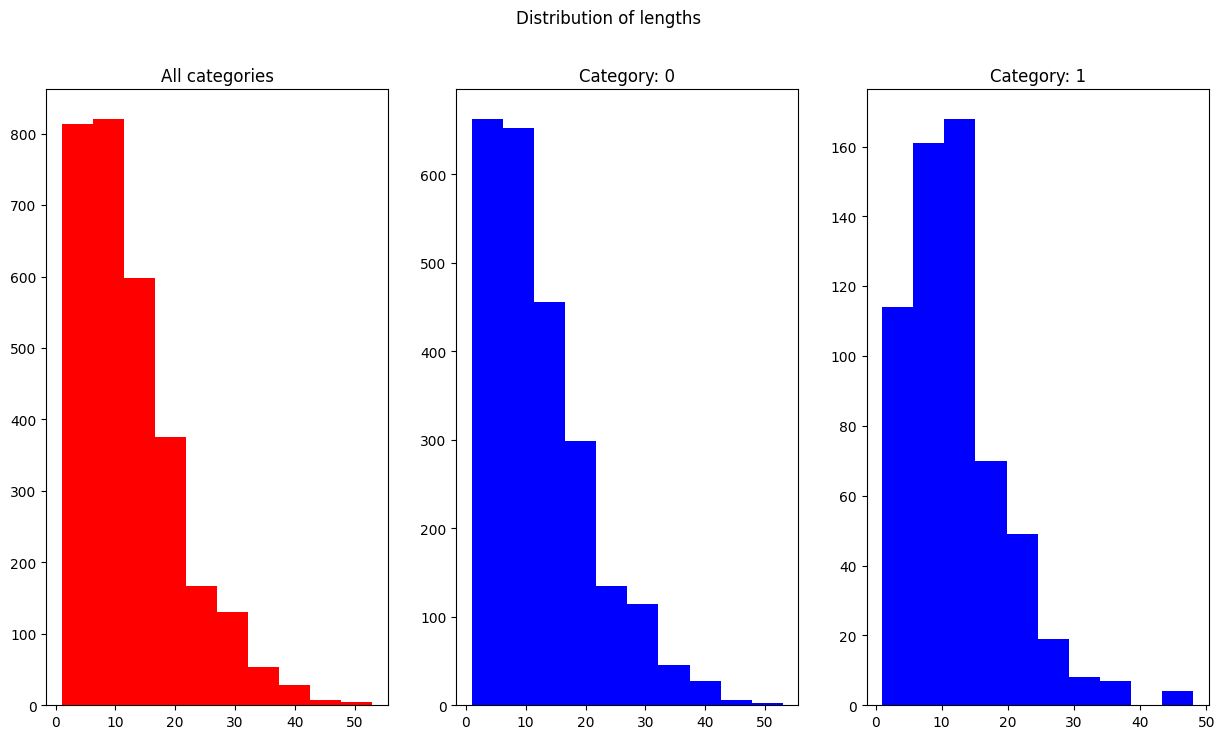

In [10]:
display_lengths_histograms(df_stats)

In [11]:
n_texts = len(X_data)
print('Texts in dataset: %d' % n_texts)

categories = df['Hateful'].unique()
n_categories = len(categories)
print('Number of categories: %d' % n_categories)

print('Done!')

Texts in dataset: 3000
Number of categories: 2
Done!


In [12]:
def roberta_encode(texts, tokenizer):
    ct = len(texts)
    input_ids = np.ones((ct, MAX_LEN), dtype='int32')
    attention_mask = np.zeros((ct, MAX_LEN), dtype='int32')
    token_type_ids = np.zeros((ct, MAX_LEN), dtype='int32') # Not used in text classification

    for k, text in enumerate(texts):
        # Tokenize
        tok_text = tokenizer.tokenize(text)

        # Truncate and convert tokens to numerical IDs
        enc_text = tokenizer.convert_tokens_to_ids(tok_text[:(MAX_LEN-2)])

        input_length = len(enc_text) + 2
        input_length = input_length if input_length < MAX_LEN else MAX_LEN

        # Add tokens [CLS] and [SEP] at the beginning and the end
        input_ids[k,:input_length] = np.asarray([0] + enc_text + [2], dtype='int32')

        # Set to 1s in the attention input
        attention_mask[k,:input_length] = 1

    return {
        'input_word_ids': input_ids,
        'input_mask': attention_mask,
        'input_type_ids': token_type_ids
    }

In [13]:
X_train, X_test, y_train, y_test = train_test_split(X_data, y_data, test_size=0.3, random_state=777)

In [14]:
tokenizer = AutoTokenizer.from_pretrained("cardiffnlp/twitter-roberta-base-emotion")

config.json:   0%|          | 0.00/768 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/150 [00:00<?, ?B/s]

In [15]:
X_train = roberta_encode(X_train, tokenizer)
X_test = roberta_encode(X_test, tokenizer)

y_train = np.asarray(y_train, dtype='int32')
y_test = np.asarray(y_test, dtype='int32')

In [16]:
def build_model(n_categories):
    with strategy.scope():
        input_word_ids = tf.keras.Input(shape=(MAX_LEN,), dtype=tf.int32, name='input_word_ids')
        input_mask = tf.keras.Input(shape=(MAX_LEN,), dtype=tf.int32, name='input_mask')
        input_type_ids = tf.keras.Input(shape=(MAX_LEN,), dtype=tf.int32, name='input_type_ids')

        # Import RoBERTa model from HuggingFace
        model = TFXLMRobertaForSequenceClassification.from_pretrained("cardiffnlp/twitter-roberta-base-emotion")
        x = model(input_word_ids, attention_mask=input_mask, token_type_ids=input_type_ids)

        x = x[0]

        x = tf.keras.layers.Dropout(0.1)(x)
        x = tf.keras.layers.Flatten()(x)
        x = tf.keras.layers.Dense(256, activation='relu')(x)
        x = tf.keras.layers.Dense(1, activation='sigmoid')(x)

        model = tf.keras.Model(inputs=[input_word_ids, input_mask, input_type_ids], outputs=x)
        model.compile(
            optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5),
            loss='binary_crossentropy',
            metrics=['accuracy'])

        return model

In [17]:
with strategy.scope():
    model = build_model(n_categories)
    model.summary()

You are using a model of type roberta to instantiate a model of type xlm-roberta. This is not supported for all configurations of models and can yield errors.


tf_model.h5:   0%|          | 0.00/501M [00:00<?, ?B/s]

All model checkpoint layers were used when initializing TFXLMRobertaForSequenceClassification.

All the layers of TFXLMRobertaForSequenceClassification were initialized from the model checkpoint at cardiffnlp/twitter-roberta-base-emotion.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFXLMRobertaForSequenceClassification for predictions without further training.


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_word_ids (InputLayer)    [(None, 128)]        0           []                               
                                                                                                  
 input_mask (InputLayer)        [(None, 128)]        0           []                               
                                                                                                  
 input_type_ids (InputLayer)    [(None, 128)]        0           []                               
                                                                                                  
 tfxlm_roberta_for_sequence_cla  TFSequenceClassifie  124648708  ['input_word_ids[0][0]',         
 ssification (TFXLMRobertaForSe  rOutput(loss=None,               'input_mask[0][0]',         

In [18]:
with strategy.scope():
    print('Training...')
    history = model.fit(X_train,
                        y_train,
                        epochs=EPOCHS,
                        batch_size=BATCH_SIZE,
                        verbose=1,
                        validation_data=(X_test, y_test))

Training...
Epoch 1/3
66/66 [==============================] - 3428s 51s/step - loss: 0.5277 - accuracy: 0.8619 - val_loss: 0.3911 - val_accuracy: 0.9411
Epoch 2/3
66/66 [==============================] - 3299s 50s/step - loss: 0.3490 - accuracy: 0.9481 - val_loss: 0.2814 - val_accuracy: 0.9578
Epoch 3/3
66/66 [==============================] - 3264s 49s/step - loss: 0.2446 - accuracy: 0.9700 - val_loss: 0.2162 - val_accuracy: 0.9611


In [19]:
model_filename = 'XMLRoberta_SC.pkl'
joblib.dump(model, model_filename)
print("Model saved as:", model_filename)

Keras weights file (<HDF5 file "variables.h5" (mode r+)>) saving:
...layers
......dense
.........vars
............0
............1
......dense_1
.........vars
............0
............1
......dropout
.........vars
......flatten
.........vars
......input_layer
.........vars
......input_layer_1
.........vars
......input_layer_2
.........vars
......tfxlm_roberta_for_sequence_classification
.........classifier
............dense
...............vars
..................0
..................1
............dropout
...............vars
............out_proj
...............vars
..................0
..................1
............vars
.........layers
............tfxlm_roberta_main_layer
...............embeddings
..................LayerNorm
.....................vars
........................0
........................1
..................dropout
.....................vars
..................vars
.....................0
.....................1
.....................2
...............encoder
..................laye

In [ ]:
plt.figure(figsize=(10,10))
plt.title('Accuracy')
xaxis=np.arange(len(history.history['accuracy']))
plt.plot(xaxis, history.history['accuracy'], label='Train set')
plt.plot(xaxis, history.history['val_accuracy'], label='Validation set')
plt.legend()

In [21]:
scores = model.evaluate(X_test, y_test, verbose=0)
print("Accuracy: %.2f%%" % (scores[1] * 100))

Accuracy: 96.11%


In [22]:
def plot_confusion_matrix(X_test, y_test, model):
    y_pred = model.predict(X_test)
    y_pred = [np.argmax(i) for i in model.predict(X_test)]

    con_mat = tf.math.confusion_matrix(labels=y_test, predictions=y_pred).numpy()

    con_mat_norm = np.around(con_mat.astype('float') / con_mat.sum(axis=1)[:, np.newaxis], decimals=2)
    label_names = list(range(len(con_mat_norm)))

    con_mat_df = pd.DataFrame(con_mat_norm,
                              index=label_names,
                              columns=label_names)

    figure = plt.figure(figsize=(10, 10))
    sns.heatmap(con_mat_df, cmap=plt.cm.Blues, annot=True)
    plt.ylabel('True label')
    plt.xlabel('Predicted label')